In [1]:
# read the tsv file
import json 
import re 

regexstr = r"\/\/Sent \d{1,2}:"

file_name = "/Users/daniel/ideaProjects/allennlp/ipython/multirc/multirc-Question_phenomenta_annotations-General_phenomena.tsv"
paragraphs = []
qas = []
counter = 1
latest_paragraph = ""

info_map = {}

with open(file_name) as f:
    content = f.read().splitlines()
    for line in content: 
        counter = counter + 1
        splitted = line.split("\t")
        if len(splitted) > 3: 
            p_text = splitted[0].strip()
            q_text = splitted[1].strip()
            ans_text = [x.strip() for x in splitted[2].split("//")]
            correct_or_not = splitted[3].split(",")
            phenomenon_labels = [x.strip() for x in splitted[4].split(",")]
            
            assert len(ans_text) == len(correct_or_not), f"{ans_text} - {correct_or_not}"
            
            if len(p_text.strip()) > 10: 
                paragraphs.append({"context": latest_paragraph, "qas": qas})
                latest_paragraph = re.sub(regexstr, "", p_text).strip()
                qas = []
            elif len(q_text) > 3: 
                ans = [{"answer_start": 0, "text": latest_paragraph.split(" ")[0]}]
                # ans = [{"answer_start": 0, "text": x} for x in ans_text]
                question = {"answers": ans, "question": q_text, "id": str(counter)}
                qas.append(question)
                info_map[q_text] = (ans_text, correct_or_not, phenomenon_labels)
                    
    data = {"data": [{"paragraphs": paragraphs}]}
    
    # save data on disk 
    with open('/Users/daniel/ideaProjects/allennlp/QA_datasets/mutlirc_questions.json', 'w', newline='') as f:
        f.write(json.dumps(data))

In [2]:
def load_questions(activation_f, question_f, max_size = -1):
    activations_file = "/Users/daniel/ideaProjects/allennlp/" + activation_f
    questions_file = "/Users/daniel/ideaProjects/allennlp/" + question_f
    features = []
    pred_ans = []
    with open(activations_file) as f:
        content = f.read().splitlines()
        for i, l in enumerate(content):
            if (max_size > -1 and len(pred_ans) > max_size):
                break

            if i % 2 == 0:
                # print(l)
                data = json.loads(l)
                features.append(data)
            else:
                pred_ans.append(l)

    questions = []
    labels = []
    with open(questions_file) as f:
        content = f.read().splitlines()
        for i, l in enumerate(content):
            if i % 3 == 0:
                questions.append({})
                questions[int(i / 3)]["q"] = l
            elif i % 3 == 1:
                questions[int(i / 3)]["p"] = l
            elif i % 3 == 2:
                ans = json.loads(l)
                questions[int(i / 3)]["a"] = [c['text'] for c in ans]
                labels.append(ans[0]['text'])

            if (max_size > -1 and len(labels) > max_size):
                break
    mat = numpy.array(features)

    return (mat, labels, questions, pred_ans)

In [47]:
import json
import numpy
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# (mat, labels, questions, pred_ans) = load_questions("ipython/babi/out3.txt", "ipython/babi/out22.txt", max_size=0)
(mat_ad, labels_ad, questions_ad, pred_ans_ad) = load_questions("ipython/multirc/out33-ner-test.txt", "ipython/multirc/out22-ner-test.txt", max_size=-1)

# read the questions and remember question ids:
# question_paragraph_id_map = {}
# ff = "/Users/daniel/ideaProjects/allennlp/QA_datasets/mutlirc_questions.json"
# with open(ff) as file:
#     dataset_json = json.load(file)
#     dataset = dataset_json['data']
#     for article in dataset:
#         for paragraph in article['paragraphs']:
#             for qa in paragraph['qas']:
#                 key = qa['question'] + paragraph['context']
#                 id = qa['id']
#                 print(id)
#                 question_paragraph_id_map[key] = id
# bibi_reasoning_types = [question_paragraph_id_map[x["q"]+x["p"]] for x in questions_ad]

multirc_reasoning_types = [info_map[x["q"]][2] for x in questions_ad]

multirc_reasoning_types, pred_ans_ad, questions_ad

len(multirc_reasoning_types), len(questions_ad), len(info_map), info_map

(65,
 65,
 76,
 {'Question': (['Options'], ['Labels '], ['Phenomena']),
  'Who does "The Octopus" terrorize?': (['Railroad magnates and other captains of industry',
    'The spider',
    'Mr. Wentworth',
    'Ram Singh',
    'Norvell Page'],
   ['1', '0', '0', '0', '0'],
   ['Coref', 'Lex', 'Common']),
  'How is octopus different from the spider?': (['Octopus is the criminalogist',
    'Octopus is villain in white',
    'The octopus is garbed completely in light weight full length costume and is only ever seen sitting in a chair while the Spider is garbed in a white costume.',
    'Octoups is poor man',
    'They dress and look differently.'],
   ['0', '1', '0', '0', '1'],
   ['Coref', 'Lex', 'Common']),
  "Who knows the spider's other identity and why?": (["Only Jackson and Ram Singh, because he doesn't trust his fiance. This is to keep his identity a secret.",
    'The police he secretly works for, and a few others, to keep his position secret.',
    'Jackson and Ram Singh, his butle

{'Other', 'Coref', 'Cause', 'Math', 'Common', 'Lex', 'List', 'Sp-temp'}
Other -> 100.0 0
Coref -> 40.472457413967476 0
Cause -> 35.75757575757576 0
Math -> 13.96825396825397 0
Common -> 29.238100773906403 0
Lex -> 36.95434134383066 0
List -> 43.65079365079365 0
Sp-temp -> 38.46560846560847 0


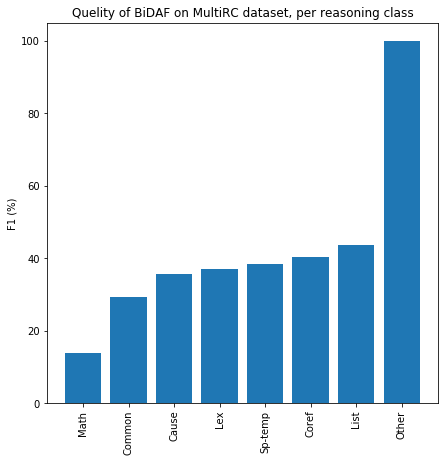

In [4]:
from evaluate11 import metric_max_over_ground_truths, f1_score, exact_match_score

# find the quality per reasoning type
scores = []
unique_types111 = set([y for x in multirc_reasoning_types for y in x])
print(unique_types111)

scores_zipped_labels= []
for t in unique_types111:
#     print(t)
    scores_ins = []
    # select questions which contain the reasoning type 
    for i, x  in enumerate(questions_ad): 
        question = x["q"]
        (ans_text, correct_or_not, phenomenon_labels) = info_map[question]
        if t in phenomenon_labels: # check if the target phenomena is included 
            correct_ans = [a for (a, c) in zip(ans_text,correct_or_not) if c == "1"]
            predicted_label = pred_ans_ad[i]
            max_f1 = max([f1_score(predicted_label,y) for y in correct_ans])
#             print(str(c) + " -> " + str(100.0 * max_f1))
            scores_ins.append(100.0 * max_f1)
    scores_zipped_labels.append((sum(scores_ins) / len(scores_ins), t))
    print(str(t) + " -> " + str(sum(scores_ins) / len(scores_ins)), len(scores))
# similarity = [f1_score(x,y) for x,y in zip(pred_ans, labels)]

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['axes.unicode_minus'] = False
fig, ax = plt.subplots(figsize=(7, 7))

# scores_zipped_labels = list(zip(scores,unique_types111))
scores_zipped_labels.sort(key=lambda x: x[0])
scores22, unique_types22 = zip(*scores_zipped_labels)

plt.bar(range(len(scores22)), scores22)
# ax.plot(range(len(scores)), scores, 'o')
ax.set_ylabel('F1 (%)')
ax.set_title('Quelity of BiDAF on MultiRC dataset, per reasoning class')
# ax.set_yticks(range(len(q_labels)))
# ax.set_xticks(range(len(bibi_reasoning_types)))
ax.set_xticks(np.arange(len(unique_types22)))

# ax.set_yticklabels(q_labels)
ax.set_xticklabels(unique_types22, rotation=90)
plt.show()

In [5]:
# mat_concat = np.concatenate((mat, mat_ad), axis=0)
# reasoning_types = ["squad"]*len(pred_ans) + bibi_reasoning_types
unique_reasoning_types = list(unique_types111) # list(set(bibi_reasoning_types))
# # unique_reasoning_types_indices = list(range(len(unique_reasoning_types)))
multirc_reasoning_type_indices = [unique_reasoning_types.index(x) for coll in multirc_reasoning_types for x in coll]
# labels_concat = np.concatenate((labels, labels_ad))
# pred_concat = np.concatenate((pred_ans, pred_ans_ad))

# multirc_reasoning_type_indices
# unique_reasoning_types.index(x) 

In [6]:
from sklearn.cluster import KMeans
db = KMeans(n_clusters=len(unique_reasoning_types), random_state=2).fit(mat_ad)
# db = DBSCAN(eps=0.3, min_samples=10).fit(mat_ad)
# core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
# core_samples_mask[db.core_sample_indices_] = True

# labelsss = db.labels_
# repeat the labels, for each category 
labelsss = []
for i, l in enumerate(db.labels_): 
    for j in range(len(multirc_reasoning_types[i])): 
        labelsss.append(l)

len(unique_reasoning_types)

8

In [7]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn import cluster, metrics

print(len(multirc_reasoning_type_indices))
print(len(labelsss))
matt1 = confusion_matrix(multirc_reasoning_type_indices, labelsss) 

/usr/local/Cellar/python/3.6.5/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


138
138


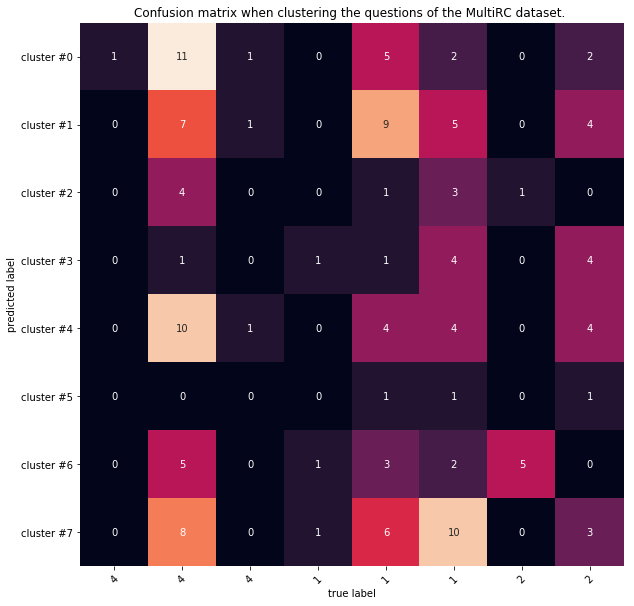

In [13]:
plt.figure(figsize=(10, 10))
sss = sns.heatmap(matt1.T, square=True,
            annot=True,
            fmt='d', cbar=False,
            xticklabels=True,
            yticklabels=True
            )

y_labels = ['cluster #' + str(i) for i in range(len(unique_reasoning_types))]
sss.set_xticklabels(labelsss, rotation=45)
sss.set_yticklabels(y_labels, rotation=0)
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.title('Confusion matrix when clustering the questions of the MultiRC dataset. ')
plt.show()

In [35]:
# clustering points into two groups
ss = len(unique_types111)
accuracy_table = np.zeros(shape=(ss, ss)) 


for ind1, type1 in enumerate(unique_types111): 
    for ind2, type2 in enumerate(unique_types111):
        
#         if ind1 > 3 or ind2 >3: 
#             continue 
        
        # we want different types 
        if type1 == type2 or ind2 <= ind1: 
            continue 
        print("type1: ", type1, " type2: ", type2)
        
        # loop through instances and select the points that have one of the two labels. 
        points = []
        labels = []
        for i, x in enumerate(multirc_reasoning_types): 
#             print(x)
            if type1 in x or type2 in x:
                points.append(mat_ad[i])
                labels.append(x)
        
        from sklearn.cluster import KMeans
        db = KMeans(n_clusters=2, random_state=2).fit(points)
        cluster_labels = db.labels_
        
        # calculate the confusion matrix 
        same_label_same_cluster = 0
        same_label_diff_cluster = 0
        diff_label_same_cluster = 0
        diff_label_diff_cluster = 0
        
        def check_if_label_is_shared(labels1, labels2): 
            label_intersection = list(set(labels1) & set(labels2))
            return (type1 in label_intersection) or (type2 in label_intersection)
            
        for ii in range(len(cluster_labels)):
            for jj in range(len(cluster_labels)):
#                 print(labels[ii], labels[jj], labels[ii] == labels[jj])
                if ii == jj: 
                    continue 
                if cluster_labels[ii] == cluster_labels[jj] and check_if_label_is_shared(labels[ii], labels[jj]): 
                    same_label_same_cluster += 1
                if cluster_labels[ii] != cluster_labels[jj] and check_if_label_is_shared(labels[ii], labels[jj]): 
                    same_label_diff_cluster += 1
                if cluster_labels[ii] == cluster_labels[jj] and not check_if_label_is_shared(labels[ii], labels[jj]): 
                    diff_label_same_cluster += 1
                if cluster_labels[ii] == cluster_labels[jj] and not check_if_label_is_shared(labels[ii], labels[jj]): 
                    diff_label_diff_cluster += 1
        total_pairs = same_label_same_cluster + same_label_diff_cluster + diff_label_same_cluster + diff_label_diff_cluster
        print("same_label_same_cluster: ", same_label_same_cluster / total_pairs, same_label_same_cluster)
        print("same_label_diff_cluster: ", same_label_diff_cluster / total_pairs, same_label_diff_cluster)
        print("diff_label_same_cluster: ", diff_label_same_cluster / total_pairs, diff_label_same_cluster)
        print("diff_label_diff_cluster: ", diff_label_diff_cluster / total_pairs, diff_label_diff_cluster)
        print("---------")
        accuracy_table[ind1][ind2] = (diff_label_diff_cluster + same_label_same_cluster) / total_pairs
        accuracy_table[ind2][ind1] = accuracy_table[ind1][ind2] 
accuracy_table


type1:  Other  type2:  Coref
same_label_same_cluster:  0.5507246376811594 1140
same_label_diff_cluster:  0.4492753623188406 930
diff_label_same_cluster:  0.0 0
diff_label_diff_cluster:  0.0 0
---------
type1:  Other  type2:  Cause
same_label_same_cluster:  0.14285714285714285 2
same_label_diff_cluster:  0.2857142857142857 4
diff_label_same_cluster:  0.2857142857142857 4
diff_label_diff_cluster:  0.2857142857142857 4
---------
type1:  Other  type2:  Math
same_label_same_cluster:  0.14285714285714285 2
same_label_diff_cluster:  0.2857142857142857 4
diff_label_same_cluster:  0.2857142857142857 4
diff_label_diff_cluster:  0.2857142857142857 4
---------
type1:  Other  type2:  Common
same_label_same_cluster:  0.45161290322580644 420
same_label_diff_cluster:  0.4838709677419355 450
diff_label_same_cluster:  0.03225806451612903 30
diff_label_diff_cluster:  0.03225806451612903 30
---------
type1:  Other  type2:  Lex
same_label_same_cluster:  0.45271629778672035 450
same_label_diff_cluster:  0.4

array([[0.        , 0.55072464, 0.42857143, 0.42857143, 0.48387097,
        0.48490946, 0.42857143, 0.56424581],
       [0.55072464, 0.        , 0.54475043, 0.54885845, 0.56200676,
        0.56354916, 0.54936015, 0.54469854],
       [0.42857143, 0.54475043, 0.        , 0.55555556, 0.48387097,
        0.48571429, 0.66666667, 0.55789474],
       [0.42857143, 0.54885845, 0.55555556, 0.        , 0.48605578,
        0.59724951, 0.75      , 0.59090909],
       [0.48387097, 0.56200676, 0.48387097, 0.48605578, 0.        ,
        0.59056806, 0.49710983, 0.60112994],
       [0.48490946, 0.56354916, 0.48571429, 0.59724951, 0.59056806,
        0.        , 0.51869919, 0.56275304],
       [0.42857143, 0.54936015, 0.66666667, 0.75      , 0.49710983,
        0.51869919, 0.        , 0.55      ],
       [0.56424581, 0.54469854, 0.55789474, 0.59090909, 0.60112994,
        0.56275304, 0.55      , 0.        ]])

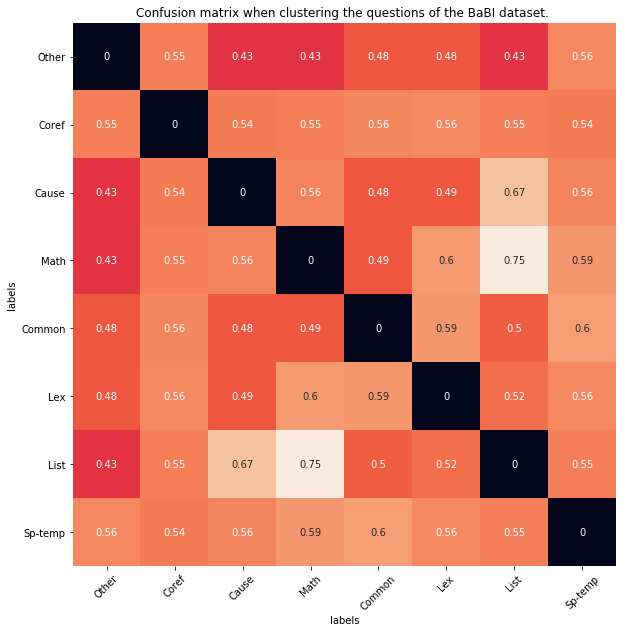

In [36]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn import cluster, metrics

plt.figure(figsize=(10, 10))
sss = sns.heatmap(accuracy_table, square=True,
            annot=True,
            cbar=False,
            xticklabels=True,
            yticklabels=True
            )

sss.set_xticklabels(unique_types111, rotation=45)
sss.set_yticklabels(unique_types111, rotation=0)
plt.xlabel('labels')
plt.ylabel('labels')
plt.title('Confusion matrix when clustering the questions of the BaBI dataset. ')
plt.show()

[[0.         1.10144928 0.85714286 0.85714286 0.96774194 0.96981891
  0.85714286 1.12849162]
 [1.10144928 0.         1.08950086 1.09771689 1.12401353 1.12709832
  1.09872029 1.08939709]
 [0.85714286 1.08950086 0.         1.11111111 0.96774194 0.97142857
  1.33333333 1.11578947]
 [0.85714286 1.09771689 1.11111111 0.         0.97211155 1.19449902
  1.5        1.18181818]
 [0.96774194 1.12401353 0.96774194 0.97211155 0.         1.18113612
  0.99421965 1.20225989]
 [0.96981891 1.12709832 0.97142857 1.19449902 1.18113612 0.
  1.03739837 1.12550607]
 [0.85714286 1.09872029 1.33333333 1.5        0.99421965 1.03739837
  0.         1.1       ]
 [1.12849162 1.08939709 1.11578947 1.18181818 1.20225989 1.12550607
  1.1        0.        ]]


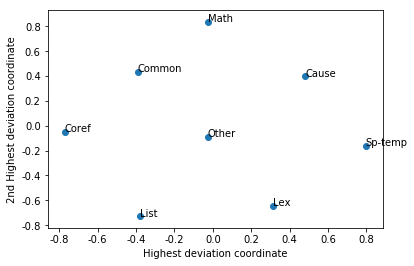

In [43]:
# Enforce triangle inequality
from scipy.sparse.csgraph import shortest_path

# dissimalrity = accuracy_table
#distanceMatrix = dissimalrity+0.5*np.eye(dissimalrity.shape[0], dissimalrity.shape[1])
distanceMatrix = accuracy_table # - np.ones(distanceMatrix.shape)
pathDistance=shortest_path(2*distanceMatrix)
print(pathDistance)

from sklearn.manifold import MDS
import matplotlib.pyplot as plt
mds=MDS(n_components=2,dissimilarity="precomputed", random_state=4)
emb=mds.fit_transform(pathDistance)
fig, ax = plt.subplots()
ax.scatter(emb[:,0],emb[:,1])
ax.set_xlabel("Highest deviation coordinate")
ax.set_ylabel("2nd Highest deviation coordinate")
for i, txt in enumerate(unique_types111):
    ax.annotate(txt, (emb[i,0],emb[i,1]))
plt.show()

In [37]:
# multirc_reasoning_types, labelsss, unique_types111
len(accuracy_table)

In [ ]:
# here I try to do permute the columns. probably not the best approach 
max_values = np.max(matt1, axis=1)
max_indices = np.argmax(matt1, axis=1)
max_indices = list(enumerate(max_indices))
max_indices.sort(key=lambda x: x[1])
new_ordering = [x[0] for x in max_indices]

matt = matt1[new_ordering, :]

# matt1, max_values, max_indices, new_ordering, matt1[new_ordering, :]
# multirc_reasoning_types

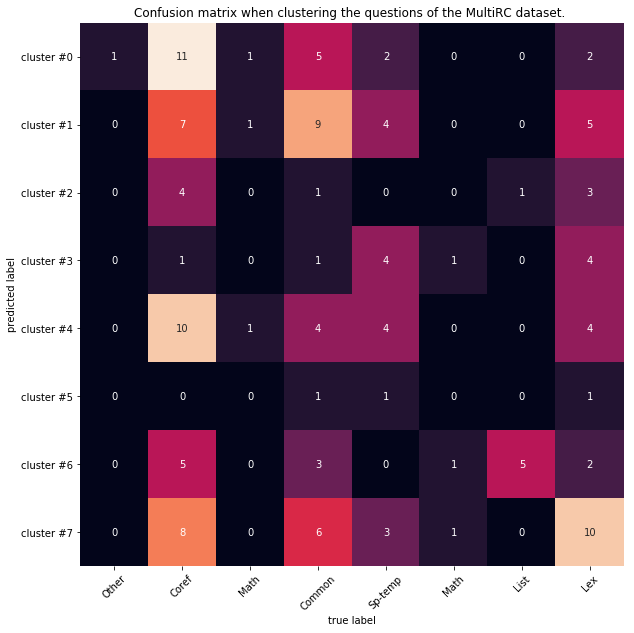

8
ars: 0.018324341235906243


In [8]:
plt.figure(figsize=(10, 10))
sss = sns.heatmap(matt.T, square=True,
            annot=True,
            fmt='d', cbar=False,
            xticklabels=True,
            yticklabels=True
            )

multirc_reasoning_types_flattened = [y for x in multirc_reasoning_types for y in x]
values, counts = np.unique(multirc_reasoning_types_flattened, return_counts=True)

# print(multirc_reasoning_types_flattened)

count_per_label = dict(zip(counts, values))

# print(count_per_label)

new_label_ordering = [count_per_label[c] for c in np.sum(matt, axis=1)]

y_labels = ['cluster #' + str(i) for i in range(len(unique_reasoning_types))]
sss.set_xticklabels(new_label_ordering, rotation=45)
sss.set_yticklabels(y_labels, rotation=0)
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.title('Confusion matrix when clustering the questions of the MultiRC dataset. ')
plt.show()
print(len(unique_reasoning_types))

# ars = metrics.adjusted_rand_score(labelsss, multirc_reasoning_type_indices)
# print("ars: " + str(ars))
# unique_reasoning_types

In [11]:
# couts of the types  
# values, counts = np.unique(multirc_reasoning_types, return_counts=True)

# count_per_label = dict(zip(counts, values))

# new_label_ordering = [count_per_label[c] for c in np.sum(matt, axis=1)]

# values, counts,dict(zip(counts, values)), new_label_ordering

In [12]:
# from evaluate11 import metric_max_over_ground_truths, f1_score, exact_match_score

# import matplotlib.pyplot as plt
# from sklearn.manifold import TSNE

# (mat, labels, questions, pred_ans) = load_questions("ipython/babi/out3.txt", "ipython/babi/out22.txt", max_size=0)
# (mat_ad, labels_ad, questions_ad, pred_ans_ad) = load_questions("ipython/multirc/out33-ner-test.txt", "ipython/multirc/out22-ner-test.txt", max_size=-1)

# # read the questions and remember question ids:
# question_paragraph_id_map = {}
# ff = "/Users/daniel/ideaProjects/allennlp/QA_datasets/mutlirc_questions.json"
# with open(ff) as file:
#     dataset_json = json.load(file)
#     dataset = dataset_json['data']
#     for article in dataset:
#         for paragraph in article['paragraphs']:
#             for qa in paragraph['qas']:
#                 key = qa['question'] + paragraph['context']
#                 id = qa['id']
#                 question_paragraph_id_map[key] = id

# bibi_reasoning_types = [question_paragraph_id_map[x["q"]+x["p"]] for x in questions_ad]

# # find the quality per reasoning type
# for c in set(bibi_reasoning_types):
#     predictions_a = np.array([pred_ans_ad[i] for i, r in enumerate(bibi_reasoning_types) if r == c])
#     labels_a = np.array([labels_ad[i] for i, r in enumerate(bibi_reasoning_types) if r == c])
#     similarity = [f1_score(x,y) for x,y in zip(predictions_a, labels_a)]
#     assert len(predictions_a) == len(labels_a)
#     print(str(c) + " -> " + str(100.0 * sum(similarity) / len(predictions_a)))

# similarity = [f1_score(x,y) for x,y in zip(pred_ans, labels)]
# # print("Squad -> ", str(100.0 * sum(similarity) / len(pred_ans)))


# mat_concat = np.concatenate((mat, mat_ad), axis=0)
# reasoning_types = ["squad"]*len(pred_ans) + bibi_reasoning_types
# unique_reasoning_types = list(set(bibi_reasoning_types))
# # unique_reasoning_types_indices = list(range(len(unique_reasoning_types)))
# bibi_reasoning_type_indices = [unique_reasoning_types.index(x) for x in bibi_reasoning_types]
# labels_concat = np.concatenate((labels, labels_ad))
# pred_concat = np.concatenate((pred_ans, pred_ans_ad))

# X_embedded = TSNE(n_components=2,init="pca").fit_transform(mat_concat)
# fig, ax = plt.subplots(figsize=(12, 12))
# for iter, c in enumerate(unique_reasoning_types):
#     X_selected = np.asarray([X_embedded[i, :] for i, r in enumerate(reasoning_types) if r == c and f1_score(pred_concat[i], labels_concat[i]) > 0.6])
#     plt.scatter(X_selected[:, 0], X_selected[:, 1], alpha=0.7, s=2, label=c) # color=color_map[iter],

# ax.legend()
# plt.show()